# OPTIMIZE MODEL

In [19]:
from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix,roc_curve,auc,accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from langdetect import detect_langs
from translate import translator
import matplotlib.pyplot as plt
from transformers import *
from custom_plot import plot_confusion_matrix
import numpy as np
import pandas as pd
% matplotlib inline
import pickle
import re

## LOAD DATA

In [12]:
df = pd.read_csv('data/161207_ZikaLabels.csv')
df.dropna(axis=0,inplace=True) #drop NaNs or else NaNs would confuse the algorithms
X = df.diagnosisRAW
y = df.zika
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## ALGORITHMS

In [13]:
models = {}
models['Logistic_Regression'] = LogisticRegression()
models['Gauss_Naive_Bayes'] = GaussianNB()
models['Random_Forest'] = RandomForestClassifier()
models['Gradient_Boost'] = GradientBoostingClassifier()

## RUN MODELS

######################################################################
######################################################################
MODEL:Logistic_Regression 	 SCORE:0.929133858268
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.00      0.00      0.00        99

avg / total       0.86      0.93      0.90      1397

Confusion matrix, without normalization
[[1298    0]
 [  99    0]]


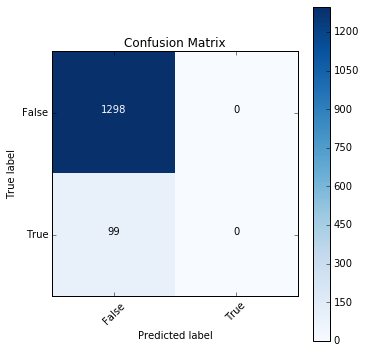

######################################################################
######################################################################
MODEL:Gradient_Boost 	 SCORE:0.926986399427
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.00      0.00      0.00        99

avg / total       0.86      0.93      0.89      1397

Confusion matrix, without normalization
[[1295    3]
 [  99    0]]


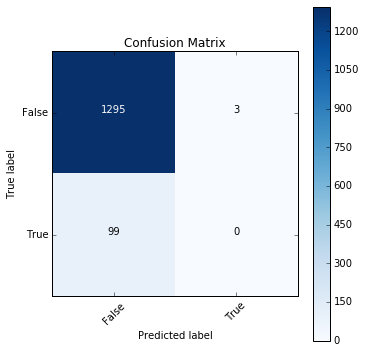

######################################################################
######################################################################
MODEL:Gauss_Naive_Bayes 	 SCORE:0.249821045097
             precision    recall  f1-score   support

      False       0.91      0.21      0.35      1298
       True       0.07      0.74      0.12        99

avg / total       0.85      0.25      0.33      1397

Confusion matrix, without normalization
[[ 276 1022]
 [  26   73]]


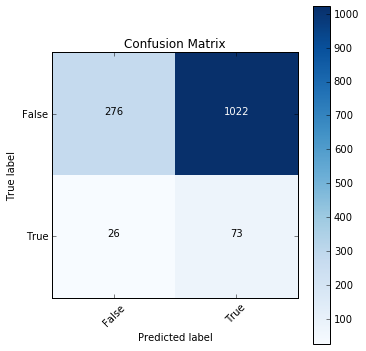

######################################################################
######################################################################
MODEL:Random_Forest 	 SCORE:0.926986399427
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.00      0.00      0.00        99

avg / total       0.86      0.93      0.89      1397

Confusion matrix, without normalization
[[1295    3]
 [  99    0]]


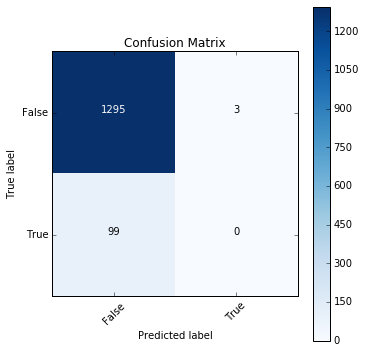

In [22]:
for name,model in models.items():
    pipe = make_pipeline(AsciiTransformer(),
                        TfidfVectorizer(),
                        TruncatedSVD(100),
                        model)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    y_pred_probs = pipe.predict_proba(X_test)
    score = accuracy_score(y_test,y_pred)

    precision,recall,threshold_PR = precision_recall_curve(y_test,y_pred_probs[:,1],pos_label=1)
    fpr,tpr,threshold_ROC = roc_curve(y_test,y_pred_probs[:,1],pos_label=1)
    AUC = auc(fpr,tpr)
    
    print '#'*70
    print '#'*70
    print 'MODEL:{} \t SCORE:{}'.format(name, score)
    print classification_report(y_test,y_pred)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    class_names = sorted(df.zika.unique())

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion Matrix')
    plt.show()

## OPTIMIZE N_components

Algorithm of choice: Gaussian Naive Bayes

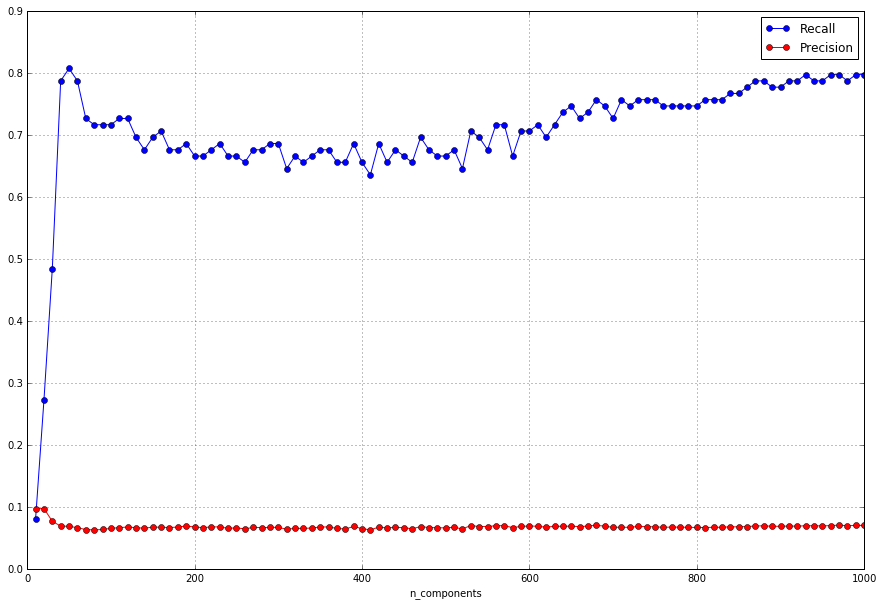

In [25]:
n_comps = []
recalls = []
preciss = []
for n in range(10,1001,10):
    pipe = make_pipeline(AsciiTransformer(),
                         LowerCaseTransformer(),
                         RemoveSymsTransformer(),
                         TfidfVectorizer(),
                         TruncatedSVD(n),                     
                         GaussianNB())
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    y_pred_probs = pipe.predict_proba(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    FP = float(cnf_matrix[0][1])
    FN = float(cnf_matrix[1][0])
    TP = float(cnf_matrix[1][1])
    recall = TP/(TP+FN)
    precis = TP/(TP+FP)
    n_comps.append(n)
    recalls.append(recall)
    preciss.append(precis)
plt.figure(figsize=(15,10))
plt.plot(n_comps,recalls,'-ob')
plt.plot(n_comps,preciss,'-or')
plt.legend(['Recall','Precision'])
plt.xlabel('n_components')
plt.grid(True)
plt.show()

## SAVE PROTOTYPE MODEL

In [29]:
pipe = make_pipeline(AsciiTransformer(),
                     LowerCaseTransformer(),
                     RemoveSymsTransformer(),
                     TfidfVectorizer(),
                     TruncatedSVD(50),                     
                     GaussianNB())
pipe.fit(X_train,y_train)
# with open('Naive_Bayes_MODEL2.plk','wb') as f:
#     pickle.dump(pipe,f)

## TEST RUN

In [31]:
with open('Naive_Bayes_MODEL2.plk','rb') as f:
    pipe = pickle.load(f)
text = 'Eu tenho o virus zika'
print 'TEXT_INPUT: \"{}\"'.format(text)
print 'PREDICTION: {}'.format(pipe.predict(pd.Series(text))[0])
print 'FALSE_PROB: {} \t TRUE_PROB: {}'.format(pipe.predict_proba(pd.Series(text))[0][0],
                                               pipe.predict_proba(pd.Series(text))[0][1])

TEXT_INPUT: "Eu tenho o virus zika"
PREDICTION: True
FALSE_PROB: 1.81933899917e-05 	 TRUE_PROB: 0.99998180661
